In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Define paths
train_dir = '/kaggle/input/fruit-and-vegetable-image-recognition/train'
test_dir = '/kaggle/input/fruit-and-vegetable-image-recognition/test'
val_dir = '/kaggle/input/fruit-and-vegetable-image-recognition/validation'

datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


2024-08-14 04:50:56.398448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 04:50:56.398603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 04:50:56.589189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(36, activation='softmax')(x)  # 36 classes for 36 fruits/vegetables


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Create the model
model = models.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    TensorBoard(log_dir='./logs')
]




In [4]:
# Train the model with validation data
history = model.fit(
    train_generator,
    epochs=20,  # Fewer epochs due to smaller model
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.0778 - loss: 3.6294 - val_accuracy: 0.4530 - val_loss: 2.2966 - learning_rate: 1.0000e-04
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.3596 - loss: 2.3533 - val_accuracy: 0.6268 - val_loss: 1.3886 - learning_rate: 1.0000e-04
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.5205 - loss: 1.7191 - val_accuracy: 0.7607 - val_loss: 0.9026 - learning_rate: 1.0000e-04
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.6227 - loss: 1.4020 - val_accuracy: 0.7920 - val_loss: 0.6544 - learning_rate: 1.0000e-04
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.6741 - loss: 1.1787 - val_accuracy: 0.8291 - val_loss: 0.5033 - learning_rate: 1.0000e-04
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.7368 - loss: 0.9608 - val_accuracy: 0.8433 - val_loss: 0.4684 - learning_rate: 1.0000e-04
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.7381 - loss: 0.8

In [5]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9267 - loss: 0.2952
Test Accuracy: 94.99%


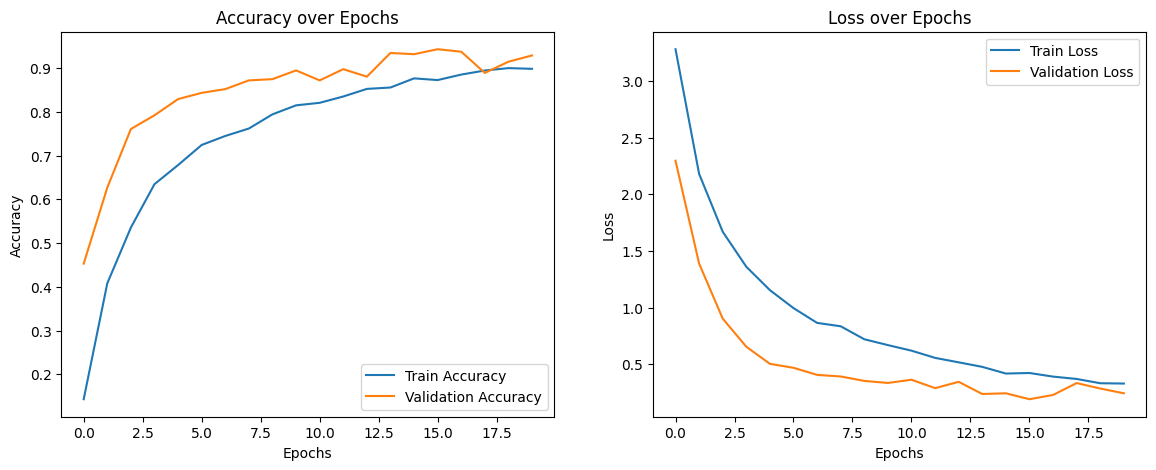

In [6]:
# Plot accuracy and loss graphs
def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [7]:
calorie_dict = {
    'apple': 52, 'banana': 89, 'beetroot': 43, 'bell paper': 31, 'cabbage': 25,
    'capsicum': 20, 'carrot': 41, 'cauliflower': 25, 'chilli paper': 40, 'corn': 86,
    'cucumber': 16, 'eggplant': 25, 'garlic': 149, 'ginger': 80, 'grapes': 69,
    'jalepeno': 29, 'kiwi': 61, 'lemon': 29, 'lettuce': 15, 'mango': 60,
    'onion': 40, 'orange': 47, 'paprika': 282, 'pear': 57, 'pineapple': 50,
    'pomergranate': 83, 'potato': 77, 'raddish': 16, 'soy beans': 446, 'spinach': 23,
    'sweetcorn': 86, 'sweetpotato': 86, 'tomato': 18, 'turnip': 28, 'watermelon': 30
}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


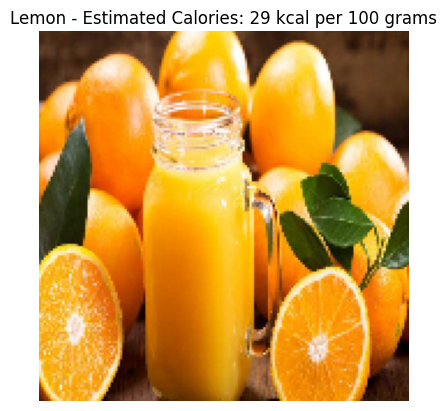

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def display_image_with_calories(img_path, model, calorie_dict):
    img = image.load_img(img_path, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[predicted_class_index]

    # Estimate calories
    estimated_calories = calorie_dict.get(predicted_class, "Unknown")

    
    plt.imshow(img)
    plt.title(f"{predicted_class.capitalize()} - Estimated Calories: {estimated_calories} kcal per 100 grams")
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/kaggle/input/fruit-and-vegetable-image-recognition/test/orange/Image_2.jpg'  
display_image_with_calories(image_path, model, calorie_dict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


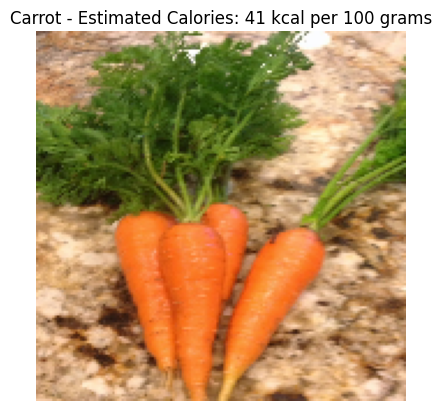

In [9]:
image_path = '/kaggle/input/fruit-and-vegetable-image-recognition/test/carrot/Image_7.JPG'  
display_image_with_calories(image_path, model, calorie_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


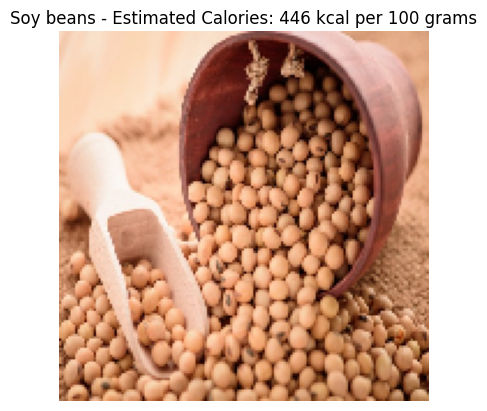

In [10]:
image_path = '/kaggle/input/fruit-and-vegetable-image-recognition/test/soy beans/Image_7.jpg'  
display_image_with_calories(image_path, model, calorie_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


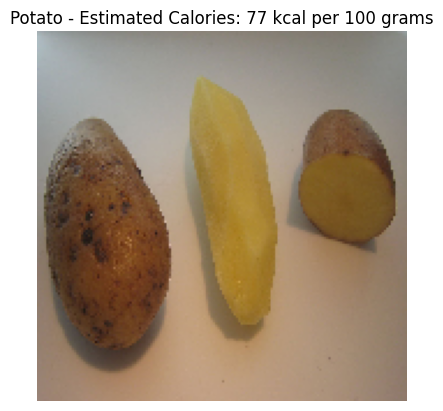

In [11]:
image_path = '/kaggle/input/fruit-and-vegetable-image-recognition/test/potato/Image_5.JPG'  
display_image_with_calories(image_path, model, calorie_dict)